<a href="https://colab.research.google.com/github/hhindley/phd/blob/main/colab_notebooks/fmfn_bayesopt_rtc_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ffrom google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install bayesian-optimization
# !pip install scipy==1.7.3
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from pandas import DataFrame
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model code

In [ ]:
#@title
def model(t, y, params):
  L, c, kr, Vmax_init, Km_init, w_ab, w_r, θ, max, thr, K1_tag, K2_tag, K1_rep, K2_rep, gr_c, d, krep, kdam, ktag, kdeg, kin, atp = params
  
  rm_a, rtca, rm_b, rtcb, rm_r, rtcr, rh, rd, rt = y

  dydt = np.zeros(9)

    # growth rate
  lam = gr_c*rh
  
  # dilution by growth and degradation 
  def dil(species):
    growth = lam*species
    return growth
  def deg(species):
    deg = d*species
    return deg
  
  # MWC
  alpha = rt/kr 
  fa = (1+alpha)**6/(L*((1+c*alpha)**6)+(1+alpha)**6)
  ra = fa*rtcr
  
  # transcription 
  Vinit = ra*Vmax_init*atp/(Km_init+atp)
  tscr_el_ab = w_ab*atp/(θ+atp)
  tscr_ab = Vinit*tscr_el_ab
  tscr_r = w_r*atp/(θ+atp)

  # translation
  tlr_el = max*atp/(thr+atp)
  def tlr(rm_x):
    tlr = rh*rm_x*tlr_el
    return tlr

  # ribosomes
  rdrtca = rtca*rd/(K1_tag+rd+K2_tag*atp)
  rtrtcb = rtcb*rt/(K1_rep+rt+K2_rep*atp)
  Vrep = krep*rtrtcb*atp
  Vdam = kdam*rh
  Vinflux = kin*tlr_el #lam*rh
  Vtag = ktag*rdrtca*atp

  # ODEs
  dydt[0] = tscr_ab - dil(rm_a) - deg(rm_a)
  dydt[1] = tlr(rm_a) - dil(rtca)    
  dydt[2] = tscr_ab - dil(rm_b) - deg(rm_b)
  dydt[3] = tlr(rm_b) - dil(rtcb)
  dydt[4] = tscr_r - dil(rm_r) - deg(rm_r)
  dydt[5] = tlr(rm_r) - dil(rtcr)
  dydt[6] = Vrep - Vdam + Vinflux - dil(rh)
  dydt[7] = Vdam - Vtag - kdeg*rd - dil(rd)
  dydt[8] = Vtag - Vrep - dil(rt)

  return dydt

In [ ]:
L = 100; c = 0.01; kr = 10; Vmax_init = 5; Km_init = 55.829; w_r = 4.14; 
θ = 20; max = 4; thr = 20; gr_c = 0.01; 
d = 0.01; krep = 1;  kdam = 0.05; ktag = 1; kdeg = 0.001; kin = 0.4; atp = 10;
K1_tag = 1; K2_tag = 10; K1_rep = 1; K2_rep = 10; 
# w_ab = 4.14;

rm_a_0 = 0; rtca_0 = 1; rm_b_0 = 0; rtcb_0 = 1; rm_r_0 = 0; rtcr_0 = 0;
rh_0 = 10; rd_0 = 0; rt_0 = 0;

# params = [L, c, kr, Vmax_init, Km_init, w_ab, w_r, θ, max, thr, K1_tag, K2_tag, K1_rep, K2_rep, gr_c, d, krep, kdam, ktag, kdeg, kin, atp]
init = [rm_a_0, rtca_0, rm_b_0, rtcb_0, rm_r_0, rtcr_0, rh_0, rd_0, rt_0]
t0 = 0
tf = 100

Solve a specific number of times and compare all time points solved

In [ ]:
t = np.logspace(-3, 2, 14)
t = np.insert(t, 0, 0, axis=0)
sol_syn = solve_ivp(model, [t0, tf], init, args=([L, c, kr, Vmax_init, Km_init, 4.14, w_r, θ, max, thr, K1_tag, K2_tag, K1_rep, K2_rep, gr_c, d, krep, kdam, ktag, kdeg, kin, atp],), method='Radau', t_eval=t)
sol_syn1 = solve_ivp(model, [t0, tf], init, args=([L, c, kr, Vmax_init, Km_init, 4.14, w_r, θ, max, thr, K1_tag, K2_tag, K1_rep, K2_rep, gr_c, d, krep, kdam, ktag, kdeg, kin, atp],), method='Radau') # normal solving

In [ ]:
np.set_printoptions(suppress = True)
t

array([  0.        ,   0.001     ,   0.00242446,   0.00587802,
         0.01425103,   0.03455107,   0.08376776,   0.20309176,
         0.49238826,   1.19377664,   2.89426612,   7.01703829,
        17.0125428 ,  41.24626383, 100.        ])

In [ ]:
np.set_printoptions(suppress = True)
print(sol_syn.t)

[  0.           0.001        0.00242446   0.00587802   0.01425103
   0.03455107   0.08376776   0.20309176   0.49238826   1.19377664
   2.89426612   7.01703829  17.0125428   41.24626383 100.        ]


Time points taken to solve: 15


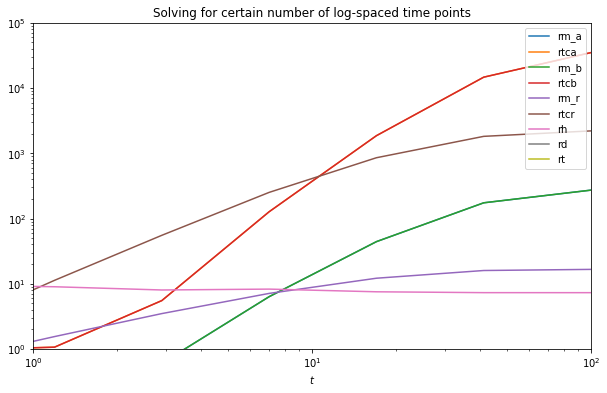

In [ ]:
print('Time points taken to solve:', len(sol_syn.t))
species = ['rm_a', 'rtca', 'rm_b', 'rtcb', 'rm_r', 'rtcr', 'rh', 'rd', 'rt']
plt.figure(figsize=(10,6))

for i in range(sol_syn.y.shape[0]):
    plt.plot(sol_syn.t, sol_syn.y[i], label=species[i])
plt.xlabel('$t$') 
plt.legend() 
plt.yscale('log')
plt.xscale('log')
plt.ylim(1,1e5)
plt.xlim(1,100)
plt.legend(loc='upper right')
plt.title('Solving for certain number of log-spaced time points')
plt.show()

Time points taken to solve: 44


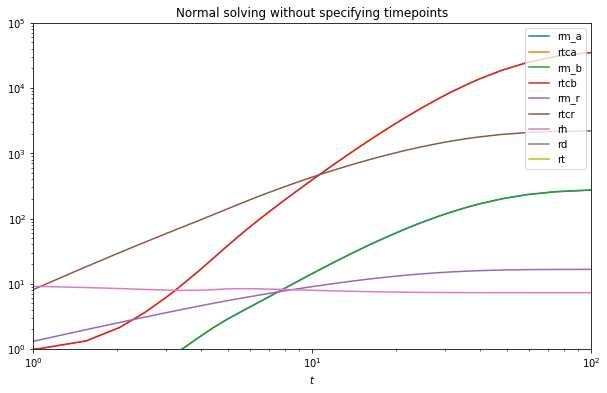

In [ ]:
print('Time points taken to solve:', len(sol_syn1.t))
species = ['rm_a', 'rtca', 'rm_b', 'rtcb', 'rm_r', 'rtcr', 'rh', 'rd', 'rt']
plt.figure(figsize=(10,6))

for i in range(sol_syn1.y.shape[0]):
    plt.plot(sol_syn1.t, sol_syn1.y[i], label=species[i])
plt.xlabel('$t$') 
plt.legend() 
plt.yscale('log')
plt.xscale('log')
plt.ylim(1,1e5)
plt.xlim(1,100)
plt.legend(loc='upper right')
plt.title('Normal solving without specifying timepoints')
plt.show()

Synthetic data try

In [ ]:
param_range = {'w_ab': (0, 50)}#,'K1_tag': (0.9, 1.1), 'K2_tag': (9.9, 10.1), 'K1_rep': (0.9, 1.1), 'K2_rep': (9.9, 10.1)}

In [ ]:
def func_syn(w_ab):
  sol = solve_ivp(model, [t0, tf], init, args=([L, c, kr, Vmax_init, Km_init, w_ab, w_r, θ, max, thr, K1_tag, K2_tag, K1_rep, K2_rep, gr_c, d, krep, kdam, ktag, kdeg, kin, atp],), method='Radau', t_eval=t)
  obj=[]
  for i, j in zip(sol.y[1], sol_syn.y[1]):
    obj.append(np.square(i-j))

  return -np.sum(obj) 

In [ ]:
# m = []
optimizer = BayesianOptimization(func_syn, param_range, random_state=27, verbose=2) # verbose = 1 prints only when a maximum is observed (pink)
start = time.time()
optimizer.maximize(init_points=2, n_iter=10, acq='ucb', kappa=1)
end = time.time()
print(end-start, "seconds")

|   iter    |  target   |   w_ab    |
-------------------------------------
| 1         | -2.478e+1 | 21.29     |
| 2         | -1.128e+1 | 40.73     |
| 3         | -2.684e+1 | 21.99     |
| 4         | -9.671e+0 | 7.527     |
| 5         | -1.445e+0 | 0.0       |
| 6         | -6.202e+0 | 3.869     |
| 7         | -4.186e+0 | 4.845     |
| 8         | -4.044e+0 | 4.071     |
| 9         | -2.089e+0 | 4.135     |
| 10        | -3.778e+0 | 4.161     |
| 11        | -9.613e+0 | 4.174     |
| 12        | -1.285e+0 | 4.179     |
2.2459206581115723 seconds


2.252318859100342 seconds


In [ ]:
# optimizer.maximize(init_points=2, n_iter=10, acq='ucb', kappa=2)

In [ ]:
print(optimizer.max)

{'target': -2088.7952556803875, 'params': {'w_ab': 4.135043995045719}}


Best result: {'w_ab': 4.140643872027786}; f(x) = -34.920.


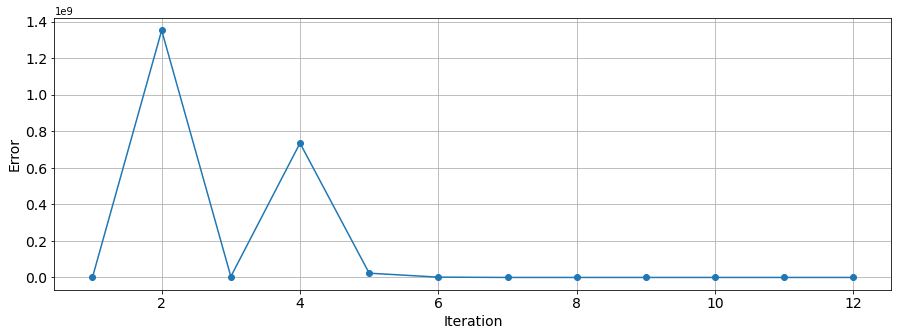

In [ ]:
# plotting error
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), -optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
df = pd.json_normalize(optimizer.res)
df.rename(columns={'params.w_ab':'w_ab'}, inplace=True)#{'params.K1_rep': 'K1_rep', 'params.K2_rep': 'K2_rep', 'params.K1_tag': 'K1_tag', 'params.K2_tag': 'K2_tag', 'params.w_ab': 'w_ab'}, inplace=True)
df

,target,w_ab
0,-1.157905e+06,4.257214
1,-1.352370e+09,8.145837
2,-5.005242e+06,4.383731
3,-7.351708e+08,1.186422
4,-2.330041e+07,3.614208
5,-1.661996e+06,3.999596
6,-5.663239e+01,4.139199
7,-7.198988e+01,4.140923
8,-8.552038e+01,4.141006
9,-7.197582e+01,4.140923


In [ ]:
df.w_ab

0     4.257214
1     8.145837
2     4.383731
3     1.186422
4     3.614208
5     3.999596
6     4.139199
7     4.140923
8     4.141006
9     4.140923
10    4.140796
11    4.140644
Name: w_ab, dtype: float64

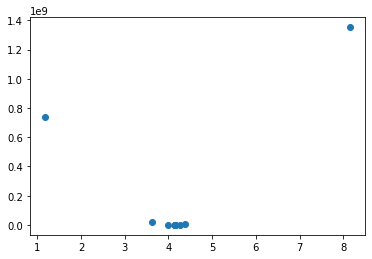

In [ ]:
plt.scatter(df.w_ab, -df.target)

AttributeError: ignored

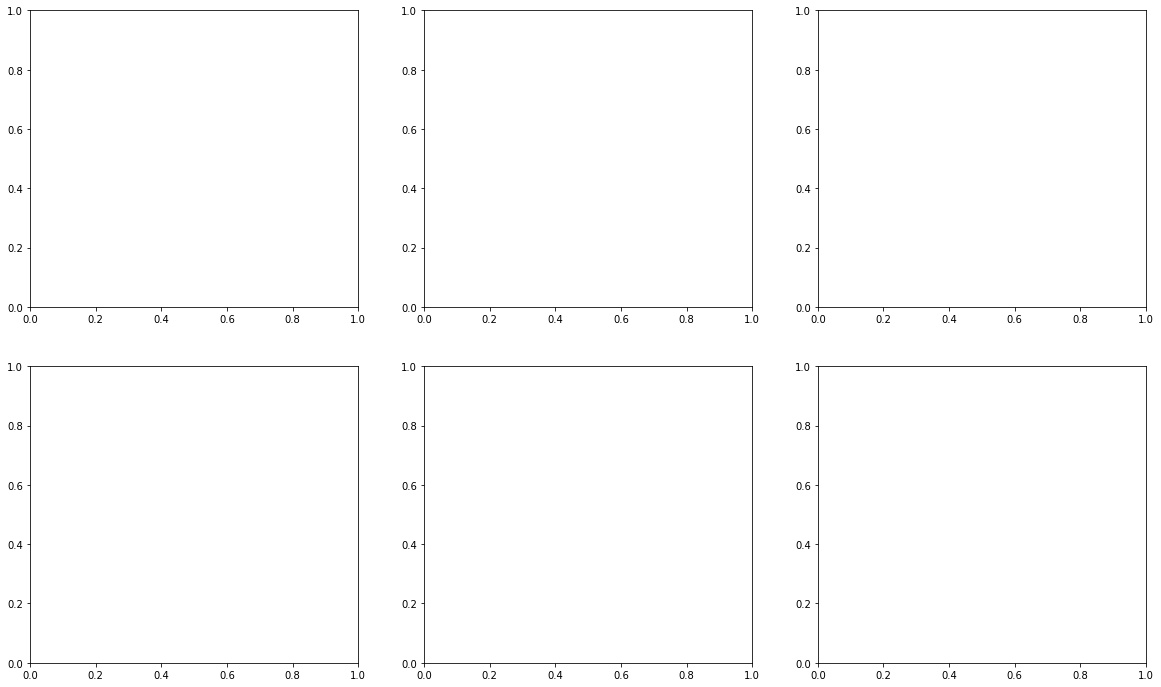

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,12))
ax[0,0].scatter(df.K1_rep, -df.target)
ax[1,0].scatter(df.K2_rep, -df.target)
ax[0,1].scatter(df.K1_tag, -df.target)
ax[1,1].scatter(df.K2_tag, -df.target)
ax[0,2].scatter(df.w_ab, -df.target)